### Testing out the new project

In [106]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np

from src.clean import detect_na, standardize_columns, impute_nas
from src.eda import extended_describe, plot_correlation_heatmap, plot_dists, calc_vif, feat_select
from src.train import train_model
from src.tune import grid_search
from src.eval import eval_classification
from src.predict import load_trained_model, make_preds

# df = pd.read_csv('../data/Breast_Cancer.csv')
df = pd.read_csv('../data/heart_attack_china.csv')

df

,Patient_ID,Age,Gender,Smoking_Status,Hypertension,Diabetes,Obesity,Cholesterol_Level,Air_Pollution_Exposure,Physical_Activity,...,Hospital_Availability,TCM_Use,Employment_Status,Education_Level,Income_Level,Blood_Pressure,Chronic_Kidney_Disease,Previous_Heart_Attack,CVD_Risk_Score,Heart_Attack
0,1,55,Male,Non-Smoker,No,No,Yes,Normal,High,High,...,Low,Yes,Unemployed,Primary,Low,104,Yes,No,78,No
1,2,66,Female,Smoker,Yes,No,No,Low,Medium,High,...,High,No,Unemployed,Secondary,Middle,142,No,No,49,No
2,3,69,Female,Smoker,No,No,No,Low,Medium,High,...,Low,No,Unemployed,Primary,High,176,No,No,31,No
3,4,45,Female,Smoker,No,Yes,No,Normal,Medium,Low,...,Medium,Yes,Employed,Primary,Low,178,No,Yes,23,No
4,5,39,Female,Smoker,No,No,No,Normal,Medium,Medium,...,Low,No,Retired,Higher,Middle,146,Yes,No,79,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239261,239262,53,Male,Non-Smoker,No,No,No,Normal,Medium,Medium,...,High,Yes,Retired,Higher,Low,167,No,No,86,Yes
239262,239263,48,Female,Non-Smoker,No,No,Yes,Normal,Low,Medium,...,Medium,Yes,Unemployed,Higher,Low,179,No,No,25,No
239263,239264,57,Male,Smoker,Yes,No,No,Normal,Low,High,...,Medium,Yes,Retired,Higher,Middle,136,No,No,89,No
239264,239265,42,Female,Non-Smoker,No,No,No,High,Medium,High,...,Low,Yes,Employed,Primary,Middle,159,No,No,72,Yes


### Cleaning and Preprocessing

In [107]:
detect_na(df)

,Columns,NA_count
0,Patient_ID,0
1,Age,0
2,Gender,0
3,Smoking_Status,0
4,Hypertension,0
5,Diabetes,0
6,Obesity,0
7,Cholesterol_Level,0
8,Air_Pollution_Exposure,0
9,Physical_Activity,0


Seems like it's mostly pristine, with one column, `Education_Level` needing to be removed.

In [108]:
df.drop(['Education_Level', 'Patient_ID'], axis='columns', inplace=True)


In [109]:
if df.isna().sum().sum() == 0: 
    print('No remaining NA vals')

No remaining NA vals


### EDA

In [110]:
# This will kick off a much larger discussion about that OHE (One Hot Encoding) and the drop_first=True argument
# It's undeniable that some information will be lost, but it can be re-created, no? 
# Yes, they can! It's tedious, but it can be done... then what's the harm? 
# Well, when there's hundreds or thousands of features, categorical reconstruction doesn't feel as feasible! 
# Exploring this concept more in a blog post; for now we'll just use get_dummies as usual

df_encoded = pd.get_dummies(df, dtype=int, drop_first=True)

df_encoded = standardize_columns(df_encoded)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239266 entries, 0 to 239265
Data columns (total 44 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   age                            239266 non-null  int64
 1   blood_pressure                 239266 non-null  int64
 2   cvd_risk_score                 239266 non-null  int64
 3   gender_male                    239266 non-null  int64
 4   smoking_status_smoker          239266 non-null  int64
 5   hypertension_yes               239266 non-null  int64
 6   diabetes_yes                   239266 non-null  int64
 7   obesity_yes                    239266 non-null  int64
 8   cholesterol_level_low          239266 non-null  int64
 9   cholesterol_level_normal       239266 non-null  int64
 10  air_pollution_exposure_low     239266 non-null  int64
 11  air_pollution_exposure_medium  239266 non-null  int64
 12  physical_activity_low          239266 non-null  int64
 13 

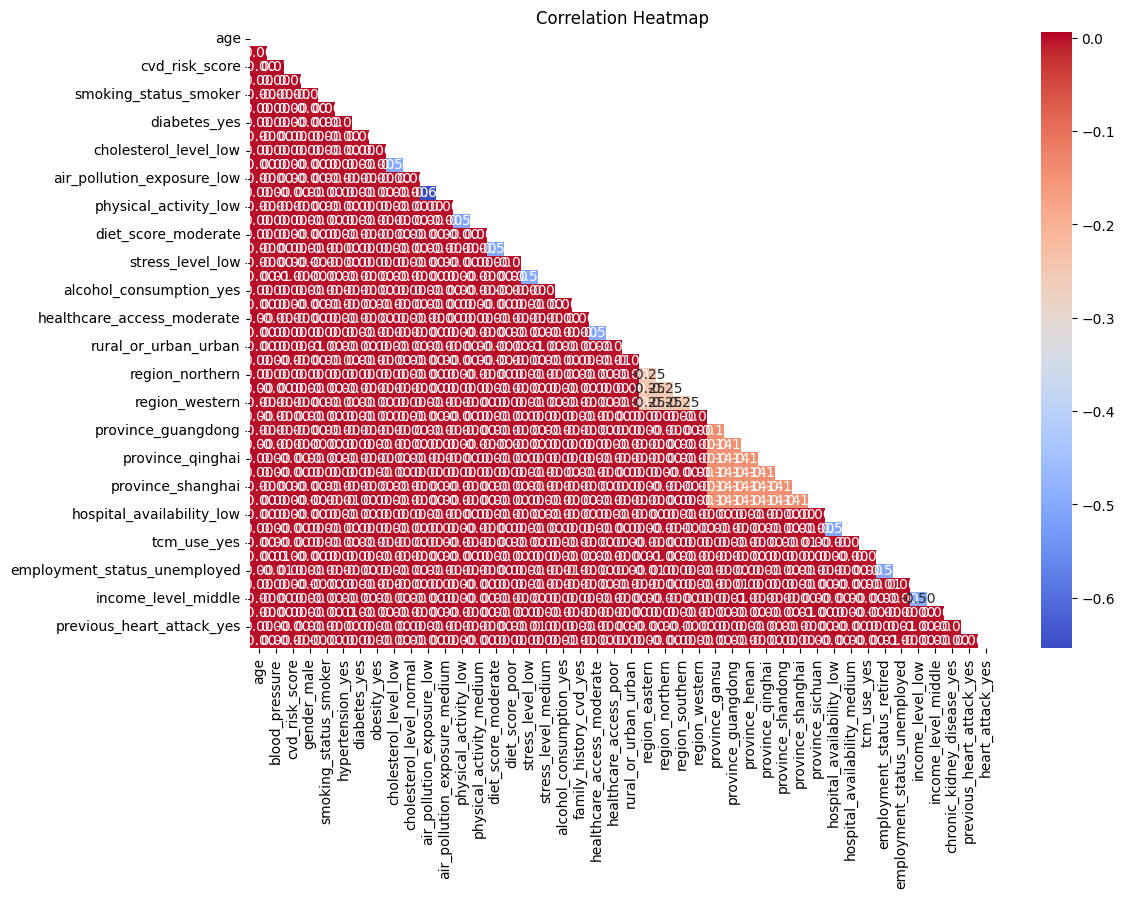

In [6]:
plot_correlation_heatmap(df_encoded)

Wow-- lots of features now, makes sense since we just performed OHE. However, there's way too much going on here, it needs to be cut down. I'll use my ElasticNet automatic feature selection function from `eda.py`

In [ ]:

# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import ElasticNetCV
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import StratifiedKFold


# def feat_select(df: pd.DataFrame, target:str, imbalance_thresh=0.15, smote_enabled=True):
#     '''
#     - Performs automatic feature selection using Elastic Net regression (but searches params that qualify as full lasso or full ridge)
#     - Handles class imbalance via SMOTE (if it exists)

#     Args: 
#         df (DataFrame): dataset that has already been OHE
#         target (str): name of target column
#         imbalance _thresh: if minority class is below this threshold, apply SMOTE

#     Returns: 
#         - selected_feats: list of selected feature names
#         - best_alpha: best alpha value chosen by ElasticNetCV
#     '''

#     # Check for imbalanced target class
#     class_counts = np.bincount(df[target])
#     min_class_ratio = class_counts.min() / class_counts.sum()

#     if min_class_ratio < imbalance_thresh and smote_enabled:
#         print(f'⚠️ Imbalanced data detected \n(Minority class = {min_class_ratio:.2%}) \nApplying SMOTE...\n')
#         smote = SMOTE(random_state=10)
#         X, y = smote.fit_resample(df.drop(columns=[target]), df[target])
#     else: 
#         X, y = df.drop(columns=[target]), df[target]

#     original_feat_count = X.shape[1]

#     # Scaling the data
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)  

#     # pre-alpha work because E-Net is finicky
#     # Now alpha is tied to signal strength!
#     min_alpha = (1.e-7) * np.median(np.abs(X_scaled.T @ y)) 

#     # pre-l1_ratio work because E-Net is finicky
#     # Hopefully this solves the SMOTE-enabled problem of killing all features
#     # By leaning more towards ridge
#     if smote_enabled:
#         l1_ratio = 0.6
#     else: 
#         l1_ratio = [0.1, 0.5, 0.9]

#     # ElasticNetCV Regularization
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10) 
#     elastic_model = ElasticNetCV(
#         # alphas = np.logspace(-6, -3, 50), 
#         alphas = np.geomspace(min_alpha, min_alpha * 100, 50),
#         l1_ratio = l1_ratio,
#         cv = cv, 
#         random_state=10
#     )
#     elastic_model.fit(X_scaled, y) 

#     # Finally, feature selection!
#     selected_feats = X.columns[elastic_model.coef_ != 0].to_list()
#     selected_feat_count = len(selected_feats)

#     print("ElasticNet Feature Selection Summary")
#     print("=====================================")
#     if smote_enabled: 
#         print('SMOTE enabled')
#     else: 
#         print('SMOTE disabled')
#     print(f"Original feature count: {original_feat_count}")
#     print(f"Selected feature count: {selected_feat_count} (🔻{original_feat_count - selected_feat_count} trimmed)")
#     print(f"Best Alpha: {elastic_model.alpha_:.2e}")
#     print(f"Best L1 Ratio: {elastic_model.l1_ratio_:.2f}")
#     print(f"Final Selected Features:")
#     print(selected_feats)

#     print('---------------')
#     nonzero_count = np.sum(elastic_model.coef_ != 0)
#     print(f"Non-zero Coefficients: {nonzero_count}/{len(elastic_model.coef_)}")
#     print("All Coefficients:", elastic_model.coef_)

#     return selected_feats

In [111]:
# Heart Attacks as target

selected_feats = feat_select(df_encoded, target='heart_attack_yes', smote_enabled=True)

⚠️ Imbalanced data detected 
(Minority class = 12.15%) 
Applying SMOTE...

ElasticNet Feature Selection Summary
Original feature count: 43
Selected feature count: 43 (🔻0 trimmed)
Best Alpha: 2.95e-05
Best L1 Ratio: 0.10 (closer to ridge)
Final Selected Features:


In [8]:
summary_stats = extended_describe(df_encoded) 
summary_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
age,239266.0,59.466284,17.348308,30.0,44.0,59.0,75.0,89.0,0.002302,-1.204728
blood_pressure,239266.0,134.513378,25.991827,90.0,112.0,135.0,157.0,179.0,-0.001079,-1.201560
cvd_risk_score,239266.0,54.485581,25.987743,10.0,32.0,54.0,77.0,99.0,0.000369,-1.200624
gender_male,239266.0,0.498683,0.499999,0.0,0.0,0.0,1.0,1.0,0.005266,-1.999989
smoking_status_smoker,239266.0,0.499733,0.500001,0.0,0.0,0.0,1.0,1.0,0.001070,-2.000016
hypertension_yes,239266.0,0.270448,0.444192,0.0,0.0,0.0,1.0,1.0,1.033580,-0.931721
diabetes_yes,239266.0,0.110638,0.313684,0.0,0.0,0.0,0.0,1.0,2.482526,4.162970
obesity_yes,239266.0,0.299855,0.458195,0.0,0.0,0.0,1.0,1.0,0.873633,-1.236776
cholesterol_level_low,239266.0,0.332496,0.471109,0.0,0.0,0.0,1.0,1.0,0.711111,-1.494333
cholesterol_level_normal,239266.0,0.334736,0.471899,0.0,0.0,0.0,1.0,1.0,0.700426,-1.509416


In [9]:
calc_vif(df_encoded[selected_feats])

,Feature,VIF
0,age,10.880375
1,blood_pressure,18.583570
2,cvd_risk_score,5.110048
3,gender_male,1.970632
4,smoking_status_smoker,1.974428
5,hypertension_yes,1.365336
6,diabetes_yes,1.123295
7,obesity_yes,1.420673
8,cholesterol_level_low,1.962609
9,cholesterol_level_normal,1.968844


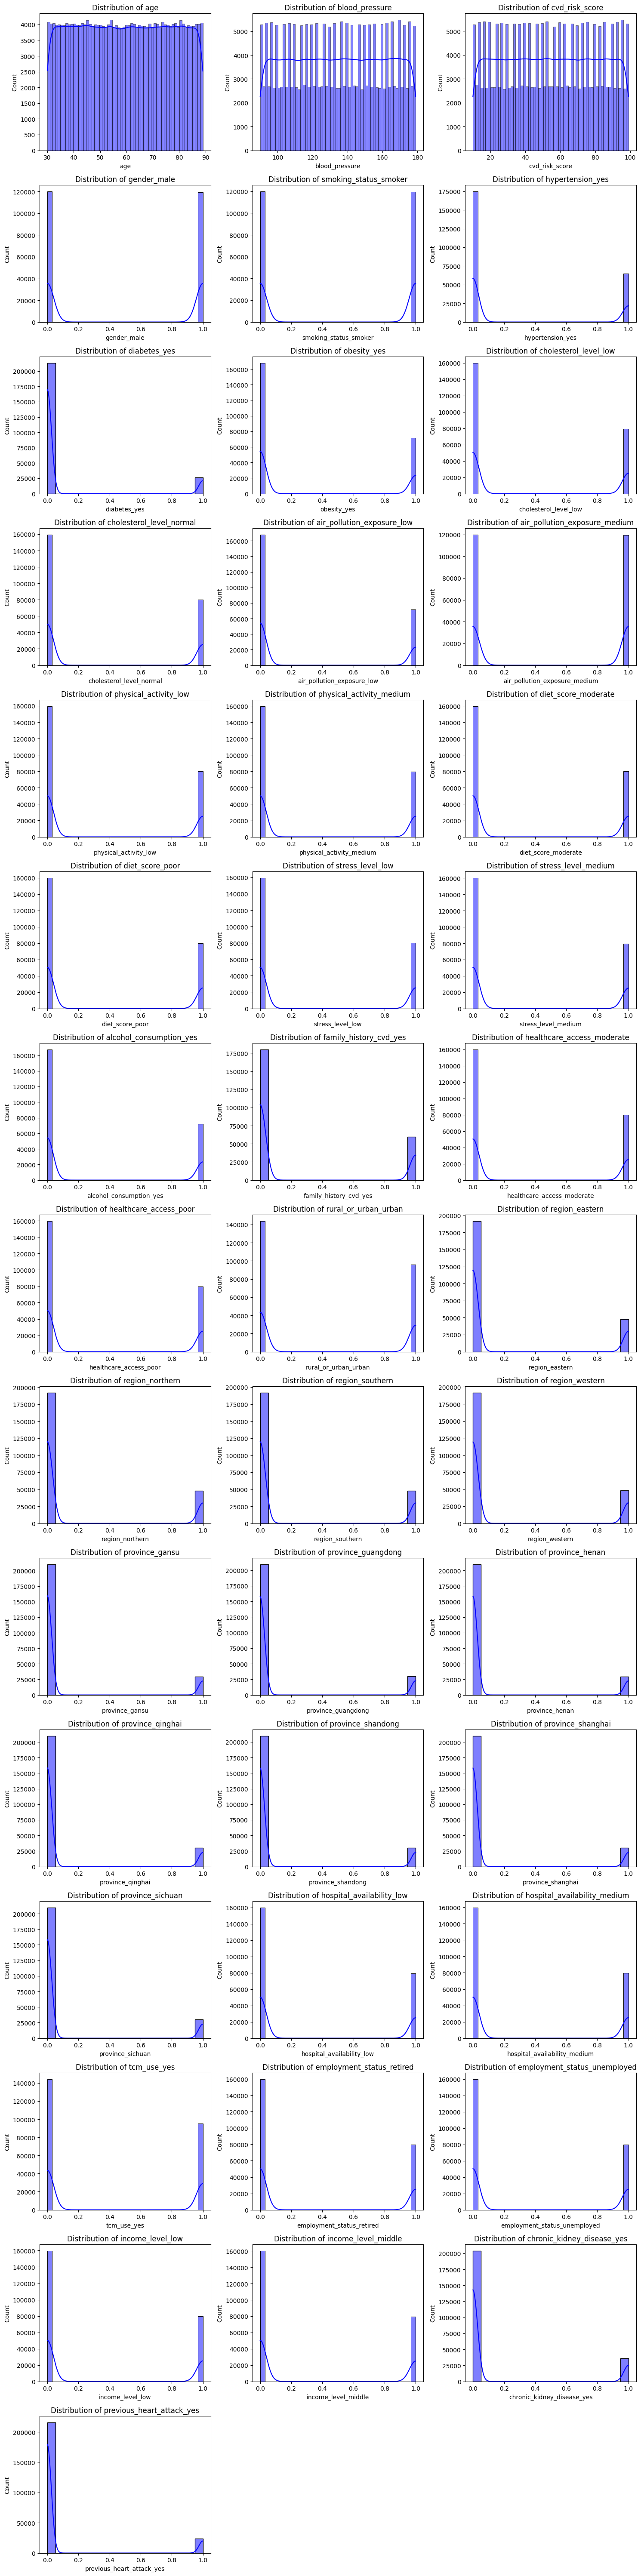

In [10]:
plot_dists(df_encoded[selected_feats], selected_feats)

In [ ]:
# df_encoded = df_encoded[selected_feats]

### Let's try out train.py 

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

X = df_encoded.drop(columns=['heart_attack_yes'])
y = df_encoded['heart_attack_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

models = {
    'RandomForest': (RandomForestClassifier, None),
    'LogisticReg': (LogisticRegression, None)
}

trained_models = train_model(X_train, y_train, models)

# Accessing the trained model:
rf_model = trained_models['RandomForest']
lr_model = trained_models['LogisticReg']

KeyError: "['heart_attack_yes'] not found in axis"

In [89]:

feat_select(df_encoded, target='heart_attack_yes', smote_enabled=True)


⚠️ Imbalanced data detected 
(Minority class = 12.15%) 
Applying SMOTE...

ElasticNet Feature Selection Summary
SMOTE enabled
Original feature count: 43
Selected feature count: 40 (🔻3 trimmed)
Best Alpha: 4.17e-03
Best L1 Ratio: 0.60
Final Selected Features:
['gender_male', 'smoking_status_smoker', 'hypertension_yes', 'diabetes_yes', 'obesity_yes', 'cholesterol_level_low', 'cholesterol_level_normal', 'air_pollution_exposure_low', 'air_pollution_exposure_medium', 'physical_activity_low', 'physical_activity_medium', 'diet_score_moderate', 'diet_score_poor', 'stress_level_low', 'stress_level_medium', 'alcohol_consumption_yes', 'family_history_cvd_yes', 'healthcare_access_moderate', 'healthcare_access_poor', 'rural_or_urban_urban', 'region_eastern', 'region_northern', 'region_southern', 'region_western', 'province_gansu', 'province_guangdong', 'province_henan', 'province_qinghai', 'province_shandong', 'province_shanghai', 'province_sichuan', 'hospital_availability_low', 'hospital_availabil

['gender_male',
 'smoking_status_smoker',
 'hypertension_yes',
 'diabetes_yes',
 'obesity_yes',
 'cholesterol_level_low',
 'cholesterol_level_normal',
 'air_pollution_exposure_low',
 'air_pollution_exposure_medium',
 'physical_activity_low',
 'physical_activity_medium',
 'diet_score_moderate',
 'diet_score_poor',
 'stress_level_low',
 'stress_level_medium',
 'alcohol_consumption_yes',
 'family_history_cvd_yes',
 'healthcare_access_moderate',
 'healthcare_access_poor',
 'rural_or_urban_urban',
 'region_eastern',
 'region_northern',
 'region_southern',
 'region_western',
 'province_gansu',
 'province_guangdong',
 'province_henan',
 'province_qinghai',
 'province_shandong',
 'province_shanghai',
 'province_sichuan',
 'hospital_availability_low',
 'hospital_availability_medium',
 'tcm_use_yes',
 'employment_status_retired',
 'employment_status_unemployed',
 'income_level_low',
 'income_level_middle',
 'chronic_kidney_disease_yes',
 'previous_heart_attack_yes']